In [0]:
import torch

import numpy as np
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# torchvision.datasets.MNIST outputs a set of PIL images
# We transform them to tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: torch.cat([x, x, x], 0))
])

# Load and transform data
trainset = datasets.MNIST('data', train=True, download=True, transform=transform)

testset = datasets.MNIST('data', train=False, download=True, transform=transform)

0it [00:00, ?it/s]

100%|█████████▉| 9912320/9912422 [00:10<00:00, 3190500.02it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz



0it [00:00, ?it/s]
  0%|          | 0/28881 [00:00<?, ?it/s]


32768it [00:00, 123203.75it/s]           
0it [00:00, ?it/s]
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz



 79%|███████▉  | 1302528/1648877 [00:01<00:00, 584282.82it/s]
1654784it [00:01, 1439343.25it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz



  0%|          | 0/4542 [00:00<?, ?it/s]
8192it [00:00, 48477.78it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [3]:
print(testset)
trainset

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test


Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train

In [0]:
# number of teachers to essemble
num_teachers = 100
batch_size = 32
def split_data_subsets(dataset, num_teachers = None):
    teacher_subsets = []
    data_size = len(dataset) // num_teachers

    for i in range(num_teachers):
        idx = list(range(i*data_size, (i+1)*data_size))
        subsets = Subset(dataset, idx)
        subsets = torch.utils.data.DataLoader(subsets, batch_size=batch_size)
        teacher_subsets.append(subsets)

    return teacher_subsets

teacherloaders = split_data_subsets(trainset, num_teachers)

In [0]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

Labels:  tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8])
Batch shape:  torch.Size([32, 1, 28, 28])


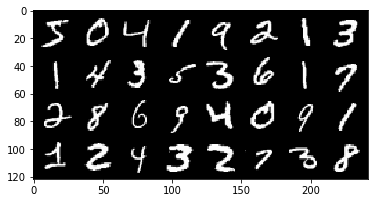

In [6]:
dataiter = iter(teacherloaders[0])
images, labels = dataiter.next()

print('Labels: ', labels)
print('Batch shape: ', images.size())
show_batch(images)

Labels:  tensor([9, 9, 8, 0, 1, 4, 4, 6, 7, 1, 5, 7, 0, 3, 5, 8, 4, 7, 1, 2, 5, 9, 5, 6,
        7, 5, 9, 8, 8, 3, 6, 9])
Batch shape:  torch.Size([32, 1, 28, 28])


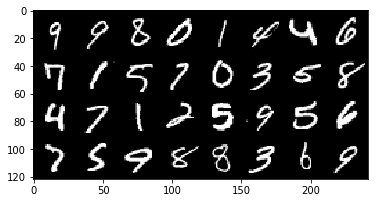

In [7]:
dataiter = iter(teacherloaders[1])
images, labels = dataiter.next()

print('Labels: ', labels)
print('Batch shape: ', images.size())
show_batch(images)

In [0]:
student_trainset = Subset(testset, list(range(9000)))
student_testset = Subset(testset, list(range(9000, 10000)))

student_train_loader = torch.utils.data.DataLoader(student_trainset)
student_test_loader = torch.utils.data.DataLoader(student_testset, batch_size=batch_size)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
def train(model, teacher_set, criterion, optimizer, epochs=None):
  model.to('cuda')
  steps = 0
  training_loss = 0
  for epoch in range(epochs):
    model.train()
    for image, label in teacher_set:
        steps += 1
        image, label = image.to('cuda'), label.to('cuda')

        optimizer.zero_grad()

        logout = model.forward(image)
        loss = criterion(logout, label)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

  return model 

In [11]:
teacher_models = []
for loader in range(len(teacherloaders)):
  print(f'Training teacher number: {loader}')
  model = Net()
  criterion = nn.NLLLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  t_model = train(model, teacherloaders[loader], criterion, optimizer, epochs = 10)
  teacher_models.append(t_model)

Training teacher number: 0
Training teacher number: 1
Training teacher number: 2
Training teacher number: 3
Training teacher number: 4
Training teacher number: 5
Training teacher number: 6
Training teacher number: 7
Training teacher number: 8


9920512it [00:29, 3190500.02it/s]                             

Training teacher number: 9
Training teacher number: 10
Training teacher number: 11
Training teacher number: 12
Training teacher number: 13
Training teacher number: 14
Training teacher number: 15
Training teacher number: 16
Training teacher number: 17
Training teacher number: 18
Training teacher number: 19
Training teacher number: 20
Training teacher number: 21
Training teacher number: 22
Training teacher number: 23
Training teacher number: 24
Training teacher number: 25
Training teacher number: 26
Training teacher number: 27
Training teacher number: 28
Training teacher number: 29
Training teacher number: 30
Training teacher number: 31
Training teacher number: 32
Training teacher number: 33
Training teacher number: 34
Training teacher number: 35
Training teacher number: 36
Training teacher number: 37
Training teacher number: 38
Training teacher number: 39
Training teacher number: 40
Training teacher number: 41
Training teacher number: 42
Training teacher number: 43
Training teacher numb

## Train different teachers models for predictions

In [0]:
def predict(model, dataloader):
    outputs = torch.zeros(0, dtype=torch.long).to('cuda')
    model.eval()
    for images, labels in dataloader:
        images, labels = images.to('cuda'), labels.to('cuda')
        output = model.forward(images)
        ps = torch.argmax(torch.exp(output), dim=1)
        outputs = torch.cat((outputs, ps))
    
    return outputs

In [13]:
len(teacher_models)

100

In [14]:
import time
preds = []
for model in range(len(teacher_models)):
  init_time = time.time()
  prediction = predict(teacher_models[model], student_train_loader)
  preds.append(prediction)
  elapsed_time = time.time()-init_time
  print(f'Predicting for teacher number: {model}, elapsed time: {round(elapsed_time)}')

Predicting for teacher number: 0, elapsed time: 7
Predicting for teacher number: 1, elapsed time: 7
Predicting for teacher number: 2, elapsed time: 7
Predicting for teacher number: 3, elapsed time: 7
Predicting for teacher number: 4, elapsed time: 7
Predicting for teacher number: 5, elapsed time: 7
Predicting for teacher number: 6, elapsed time: 7
Predicting for teacher number: 7, elapsed time: 7
Predicting for teacher number: 8, elapsed time: 7
Predicting for teacher number: 9, elapsed time: 7
Predicting for teacher number: 10, elapsed time: 7
Predicting for teacher number: 11, elapsed time: 7
Predicting for teacher number: 12, elapsed time: 7
Predicting for teacher number: 13, elapsed time: 7
Predicting for teacher number: 14, elapsed time: 7
Predicting for teacher number: 15, elapsed time: 7
Predicting for teacher number: 16, elapsed time: 7
Predicting for teacher number: 17, elapsed time: 7
Predicting for teacher number: 18, elapsed time: 7
Predicting for teacher number: 19, elapse

In [0]:
all_preds = np.array([np.array(i.cpu()) for i in preds]).transpose(1,0)

In [45]:

len(all_preds)

9000

In [0]:
!pip install syft

In [18]:
from syft.frameworks.torch.differential_privacy import pate

W0618 14:33:17.223165 140518419576704 secure_random.py:22] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow (1.14.0-rc1). Fix this by compiling custom ops.
W0618 14:33:17.441907 140518419576704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tf_encrypted/session.py:28: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [46]:
new_labels = []
for pred in all_preds:
  label_counts = np.bincount(pred, minlength = 10)
  new_label = np.argmax(label_counts)
  new_labels.append(new_label)

print(new_labels)

[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 8, 1, 7, 3, 7, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 7, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 4, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 4, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 9, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0, 3, 5, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 7, 7, 9, 2, 2, 4, 1, 5, 9, 8, 7, 2, 3, 0, 4, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 0, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2, 6, 4, 1, 5, 4, 2, 9, 2, 0, 4, 0, 0, 2, 8, 4, 7, 1, 2, 4, 0, 2, 7, 4, 3, 3, 0, 0, 5, 1, 9, 6, 5, 3, 5, 7, 7, 9, 3, 0, 4, 2, 0, 7, 1, 1, 2, 1, 

In [0]:
new_labels = []
for pred in all_preds:
  label_counts = np.bincount(pred, minlength = 10)

  epsilon = 0.1
  beta = 1 / epsilon

  for i in range(len(label_counts)):
    label_counts[i] += np.random.laplace(0, beta, 1)

  new_label = np.argmax(label_counts)

  new_labels.append(new_label)

In [48]:
print(new_labels)
new_labels = np.array(new_labels)

[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 7, 1, 7, 3, 7, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 4, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 1, 5, 4, 7, 6, 4, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 4, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 4, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 9, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0, 3, 6, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 7, 7, 9, 2, 2, 4, 1, 5, 9, 8, 7, 2, 3, 0, 4, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 0, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2, 6, 4, 1, 5, 4, 2, 9, 2, 0, 4, 0, 0, 2, 8, 4, 7, 1, 2, 4, 0, 2, 7, 4, 3, 3, 0, 0, 5, 1, 9, 6, 5, 2, 5, 7, 7, 9, 3, 0, 4, 2, 0, 7, 1, 1, 2, 1, 

In [49]:
len(new_labels)

9000

In [50]:
all_preds = all_preds.transpose(1,0)
len(all_preds)

100

In [24]:
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=all_preds, indices=new_labels, noise_eps=0.1, delta=1e-5, moments = 10)
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

Data Independent Epsilon: 371.5129254649703
Data Dependent Epsilon: 17.34492900308434


In [51]:
len(student_train_loader)

9000

In [0]:
new_labels = torch.from_numpy(new_labels)

In [0]:
def final_loader(student_train_loader, new_labels):
  for i, image in enumerate(iter(student_train_loader)):
    yield image, new_labels[i]

In [0]:
loader = final_loader(student_train_loader, new_labels)
y = [i for i in loader]

Labels:  7
Batch shape:  torch.Size([1, 1, 28, 28])


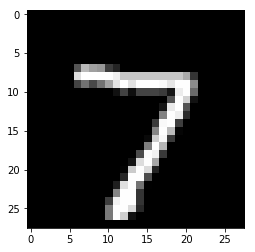

In [54]:
images, labels = y[0]

print('Labels: ', labels)
print('Batch shape: ', images[0].size())
im = torchvision.utils.make_grid(images[0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [0]:
def student_loader(student_train_loader, labels):
    for i, (data, _) in enumerate(iter(student_train_loader)):
        yield data, torch.from_numpy(labels[i*len(data):(i+1)*len(data)])

In [78]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
student_model = Net()
criterion = nn.NLLLoss()
optimizer = optim.Adam(student_model.parameters(), lr=0.001)
epochs = 10
student_model.to(device)
steps = 0
running_loss = 0
for epoch in range(epochs):
    student_model.train()
    # Model in training mode, dropout is on
    loader = student_loader(student_train_loader, new_labels)
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        steps += 1

        optimizer.zero_grad()
        output = student_model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
      
    print("Epoch: {}/{}.. ".format(epoch+1, epochs))



Epoch: 1/10.. 
Epoch: 2/10.. 
Epoch: 3/10.. 
Epoch: 4/10.. 
Epoch: 5/10.. 
Epoch: 6/10.. 
Epoch: 7/10.. 
Epoch: 8/10.. 
Epoch: 9/10.. 
Epoch: 10/10.. 


In [82]:
test_loss = 0
accuracy = 0
student_model.eval()
with torch.no_grad():
    for image, label in student_test_loader:
        image, label = image.to(device), label.to(device)
        logout = student_model.forward(image)
        batch_loss = criterion(logout, label)
        
        test_loss += batch_loss.item()
        
        #accuracy
        prob = torch.exp(logout)
        top_p, top_class = prob.topk(1, dim = 1)
        equality = top_class == label.view(*top_class.shape)
        accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
        
print(f'Test Accuracy: {accuracy/len(student_test_loader):.4f}')

Test Accuracy: 0.9453
